# Rotinas para a detecção das não-bijetividades

## Imports

In [1]:
import sys
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
sys.path.insert(0,'..')
import lib.tf_levenberg_marquardt.levenberg_marquardt as lm
import tensorflow as tf
import numpy as np
import seaborn as sns
from pathlib import Path
from matplotlib import pyplot as plt
from tensorflow import keras
from keras import layers
from itertools import product
from time import time
from scipy.optimize import root
from functools import partial
from itertools import product
import polars as pl

## Funções

In [2]:
def nmse_error(y, y_hat):
    nmse = 10*np.log10(
        np.sum(np.abs(y-y_hat)**2)/
        np.sum(np.abs(y)**2)
        )
    return nmse

In [3]:
def load_csv2numpy(p):
    return np.loadtxt(p, delimiter=',', dtype=np.float32, skiprows=1)

In [4]:
def z2n(n):
    return n if n<0 else None

In [5]:
def prep_data_y(y, M, My=1):
    a0 = np.abs(y)
    end = z2n(-M-1)
    abs = [a0[:end],]
    for m in range(My-1):
        end = z2n(-M+m)
        abs.append(a0[m+1:end])
    abs = np.array(abs).T
    return abs

In [6]:
def prep_data(x, M):
    a0 = np.abs(x)
    abs = []
    size = x.shape[0]-M
    for m in range(1,size):
        abs.append(a0[m:m+M+1])
    abs = np.array(abs)

    p0 = np.angle(x)
    phase = []
    for m in range(1,size):
        phase.append(p0[m:m+M+1])
    phase = np.array(phase)
    
    delta = []
    for m in range(1,phase.shape[1]):
        delta.append(phase[:,m]-phase[:,m-1])
    delta = np.array(delta).T
    
    d_cos = np.cos(delta)
    d_sin = np.sin(delta)
    return abs, d_cos, d_sin

In [7]:
def recuperar_data(s, x):
    y = s*np.exp(1j*np.angle(x))
    return y

In [8]:
def gerar_s(y, x, M=0):
    s = y*np.exp(-1j*np.angle(x))
    return s.real, s.imag

In [9]:
def normalize_data(x):
    return (x)/np.std(x)

In [10]:
def gen_model(M, HL, name, activation='tanh'):
    size_input = 1+3*(M)
    inputs = keras.Input(shape=(size_input,))
    hidden = layers.Dense(HL, activation=activation)(inputs)
    output = layers.Dense(1, activation='linear')(hidden)
    model = keras.Model(inputs=inputs, outputs=output, name=name)
    model = lm.ModelWrapper(model)
    model.call = tf.function(model.call)
    return model

In [11]:
def compile_model(model):
    model.compile(
        optimizer=tf.keras.optimizers.SGD(learning_rate=0.1),
        loss=lm.MeanSquaredError(),
        metrics=['accuracy','mse'],
        run_eargly=False)

In [12]:
def fit_model(model, epochs, inputs, s):
    history = model.fit(inputs, s, epochs=epochs, batch_size=3000, verbose=0)
    return history

In [13]:
def find_best_M_HL(x, y, M_min=0, M_max=10, HL_min=1, HL_max=10):    
    best_M = 0
    best_model = None
    best_nmse = np.inf
    best_y_hat = None
    metaparams = product(range(M_min,M_max+1), range(HL_min,HL_max+1))
    for M, HL in metaparams:
        start = time()
        a,dc,ds = prep_data(x, M)
        inputs = np.concatenate([a,dc,ds], axis=1)
        s_real, s_imag = gerar_s(y[M+1:], x[M+1:], M)

        model_real = gen_model(M, HL, 'parte_real')
        model_imag = gen_model(M, HL, 'parte_imag')

        compile_model(model_real)
        compile_model(model_imag)
        his = [0,0]
        his[0] = fit_model(model_real, 100, inputs, s_real)
        his[1] = fit_model(model_imag, 100, inputs, s_imag)
        
        model = (model_real, model_imag)
        # nmse = validation_models(model_real, model_imag, inputs, x, y)
        nmse, y_hat = validation(model, x, y, M)
        end = time()
        if nmse < best_nmse:
            best_nmse = nmse
            best_model = model
            best_M = M
            best_y_hat = y_hat
            print('*** BEST ***')
            print(f'Shape:{inputs.shape[1]} M:{M} HL:{HL} nmse:{nmse} time:{end-start}')
    return best_model, best_M, best_y_hat, best_nmse, his

In [14]:
def run_model(x, model, M):
    a,dc,ds = prep_data(x, M)    
    inputs = np.concatenate([a,dc,ds], axis=1)
    # Modificado por questões de performance, o model.predict acaba ficando sem o ganho de usar o tf.function no modelo
    s_hat_real = model[0](inputs).numpy().reshape(-1,)
    s_hat_imag = model[1](inputs).numpy().reshape(-1,)

    s_hat = s_hat_real + 1j*s_hat_imag
    y_hat = recuperar_data(s_hat, x[M+1:])
    return y_hat

In [15]:
def validation(model, x, y, M):
    y_hat = run_model(x, model, M)
    nmse = nmse_error(y[M+1:], y_hat)
    return nmse, y_hat

## Plot das Inversas

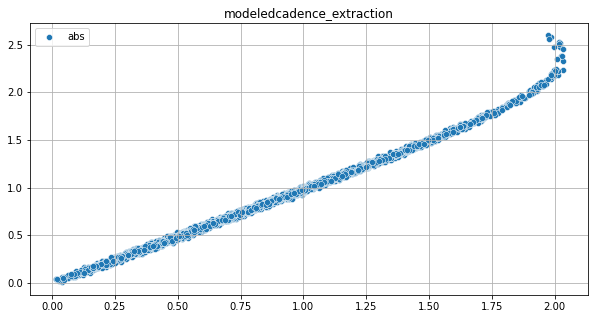

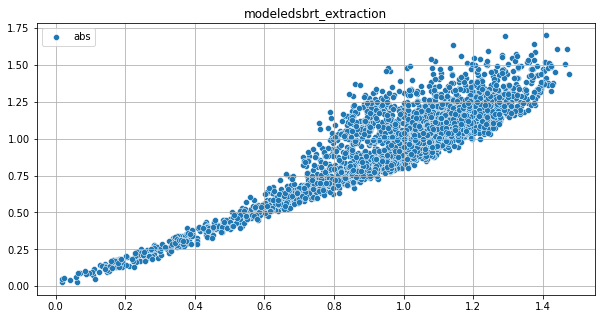

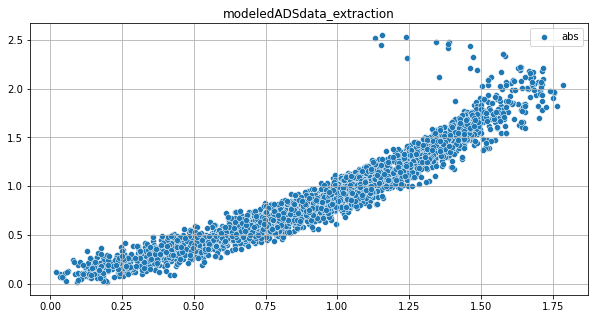

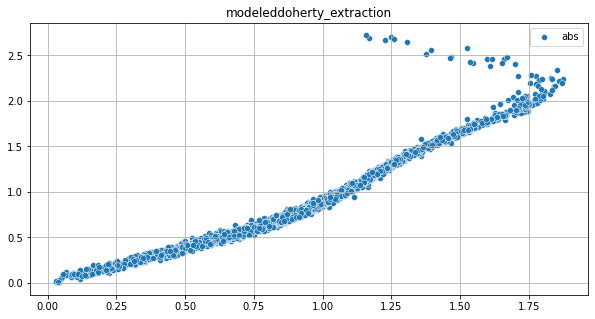

In [16]:
# plot inversa PA
for p in Path().glob('../data/*_extraction.csv'):
    data = load_csv2numpy(p)
 
    x = data[:, 2] + 1j*data[:, 3]
    x = normalize_data(x)
    x_abs = np.abs(x)

    y = data[:, 0] + 1j*data[:, 1]
    y = normalize_data(y)
    y_abs = np.abs(y)

    plt.figure(figsize=(10,5))
    sns.scatterplot(x=x_abs, y=y_abs, label='abs')
    plt.grid()
    plt.title(p.stem)
    plt.show()
    plt.close()

    # best_model, M = find_best_M_HL(x, y, M_min=3, M_max=20, HL_min=5, HL_max=20)
    '''
    pv = p.parent/p.parts[-1].replace('extraction', 'validation')
    data = load_csv2numpy(pv)

    x = data[:, 0] + 1j*data[:, 1]
    x = normalize_data(x)
    y = data[:, 2] + 1j*data[:, 3]
    y = normalize_data(y)

    nmse = validation(best_model, x, y, M)
    '''

## Treinamento da Rede Neural

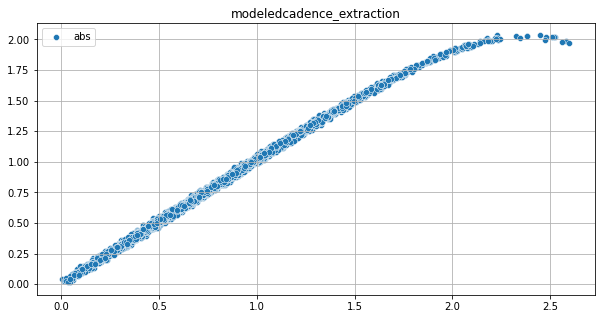

*** BEST ***
Shape:10 M:3 HL:7 nmse:-52.127652168273926 time:17.47141671180725
nmse - extraction: -52.127652168273926


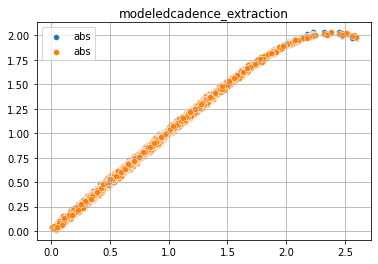

nmse - validation: -41.04581832885742


In [42]:
p = Path('../data/modeledcadence_extraction.csv')
data = load_csv2numpy(p)

x = data[:, 0] + 1j*data[:, 1]
x = normalize_data(x)
x_abs = np.abs(x)

y = data[:, 2] + 1j*data[:, 3]
y = normalize_data(y)
y_abs = np.abs(y)

plt.figure(figsize=(10,5))
ax = sns.scatterplot(x=x_abs, y=y_abs, label='abs')
plt.grid()
plt.title(p.stem)
plt.show()
plt.close()

M = 3
HL = 7

model, M, y_hat, nmse, his = find_best_M_HL(x, y, M_min=M, M_max=M, HL_min=HL, HL_max=HL)
print(f'nmse - extraction: {nmse}')

pv = p.parent/p.parts[-1].replace('extraction', 'validation')
data = load_csv2numpy(pv)

x = data[:, 0] + 1j*data[:, 1]
x = normalize_data(x)
x_abs = np.abs(x)

y = data[:, 2] + 1j*data[:, 3]
y = normalize_data(y)
y_abs = np.abs(y)

nmse, _ = validation(model, x, y, M)
print(f'nmse - validation: {nmse}')

## Carregando Rede Neural

In [16]:
model = [0,0]
M = 3
HL = 7
model[0] = gen_model(M, HL, 'parte_real', activation='tanh')
model[1] = gen_model(M, HL, 'parte_imag', activation='tanh')

model[0].load_weights('./weights/modeledcadence_extraction_real2');
model[1].load_weights('./weights/modeledcadence_extraction_imag2');


## Validação do Modelo

nmse - extraction: -42.87520408630371


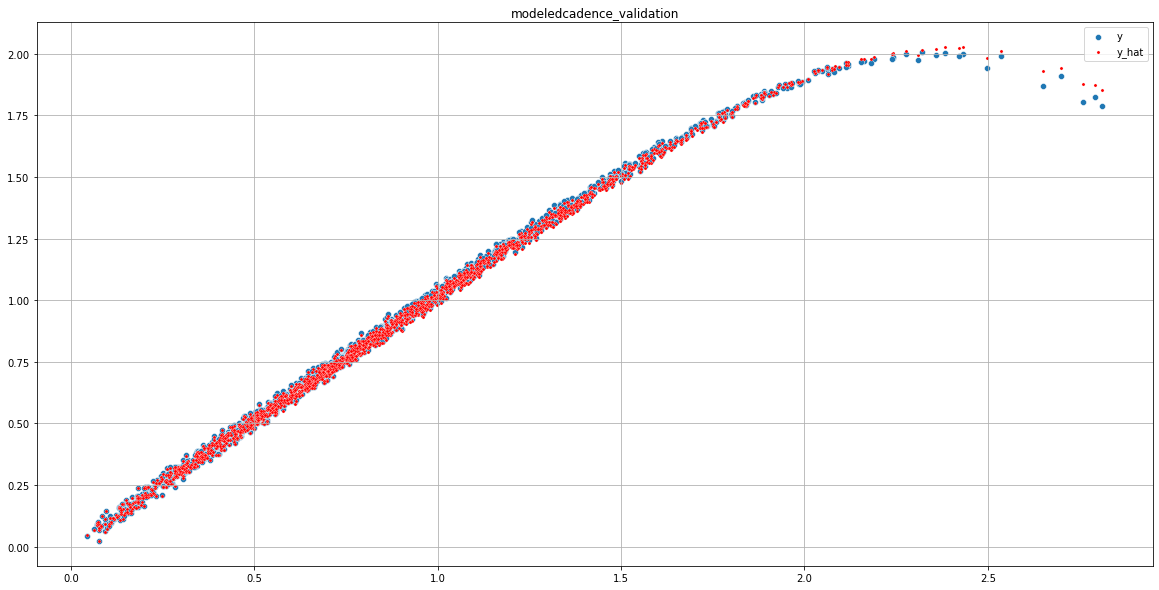

In [19]:
p = Path('../data/modeledcadence_validation.csv')
data = load_csv2numpy(p)
x = data[:, 0] + 1j*data[:, 1]
x = normalize_data(x)
x_abs = np.abs(x)

y = data[:, 2] + 1j*data[:, 3]
y = normalize_data(y)
y_abs = np.abs(y)

nmse, y_hat = validation(model, x, y, M)
print(f'nmse - extraction: {nmse}')

plt.figure(figsize=(20,10))
sns.scatterplot(x=x_abs, y=y_abs, label='y')
sns.scatterplot(x=x_abs[M+1:], y=np.abs(y_hat), label='y_hat', s=10, color='red')
plt.grid()
plt.title(p.stem)
plt.show()
plt.close()

nmse - extraction: -60.90199947357178


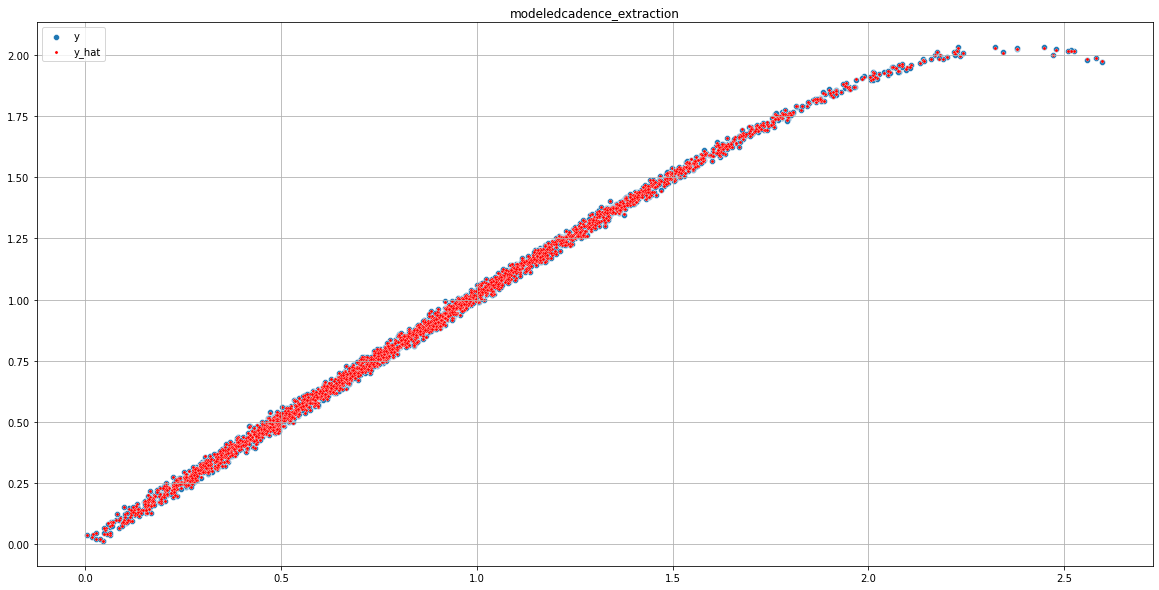

In [20]:
p = Path('../data/modeledcadence_extraction.csv')
data = load_csv2numpy(p)
x = data[:, 0] + 1j*data[:, 1]
x = normalize_data(x)
x_abs = np.abs(x)

y = data[:, 2] + 1j*data[:, 3]
y = normalize_data(y)
y_abs = np.abs(y)

nmse, y_hat = validation(model, x, y, M)
print(f'nmse - extraction: {nmse}')

plt.figure(figsize=(20,10))
sns.scatterplot(x=x_abs, y=y_abs, label='y')
sns.scatterplot(x=x_abs[M+1:], y=np.abs(y_hat), label='y_hat', s=10, color='red')
plt.grid()
plt.title(p.stem)
plt.show()
plt.close()

## Problema Inverso

In [21]:
def inverse_problem(x, y, model, M, x_old, exp=False):
    if exp:
        x = np.array([x[0]*np.exp(1j*x[1])])
    else:
        x = np.array([x[0]+1j*x[1]])
    
    if np.abs(x) > 3:
        gama = np.abs(x)
    else:
        gama = 1
    x = np.concatenate([x_old, x])

    y_hat = run_model(x, model, M)

    y_real, y_imag = y_hat.real, y_hat.imag
    output = np.array([y.real - y_real, y.imag - y_imag]).reshape(-1,)
    output *= gama
    return output

In [23]:
r_model = partial(run_model, model=model, M=M)
x01 = np.array([-2.0,2.0]) # Chute inicial de x0
x02 = np.array([2.0,-2.0]) # Chute inicial de x0
x03 = np.array([-0.5,0.5]) # Chute inicial de x0
x04 = np.array([0.5,-0.5]) # Chute inicial de x0
xs = [x01, x02, x03, x04]

for n, x_n in enumerate(x):
    if x_abs[n] < 2:
        continue

    x_old = x[n-M-1:n] # Valores de x antigos
    x_a = x[n].reshape(-1,) # Valor de x atual

    xt = x[n-M-1:n+1] # Valores de x para extrair o y0
    y0 = r_model(x=xt) # Extração do y0

    print(f'inicia o problema inverso nº {n}')

    # Problema inverso
    i_problem = partial(inverse_problem, model=model, M=M, y=y0, x_old=x_old)
    res = []
    for i, x0 in enumerate(xs):
        res.append(root(i_problem, x0=x0))

    # Erro
    print(f'x:   {x_a} -> {np.abs(x_a)}')
    for i, x0 in enumerate(xs):
        x0 = (x0[0]+1j*x0[1]).reshape(-1,)
        new_x0 = (res[i].x[0]+1j*res[i].x[1]).reshape(-1,)
        new_y0 = r_model(x=np.concatenate([x_old, new_x0]))
        error_y0 = nmse_error(y0, new_y0)
        error_x0 = nmse_error(x_a, new_x0)
        print(f'x0{i}: {x0} -> {new_x0} -> {np.abs(new_x0)} -> {error_y0} -> {error_x0}')
    print()

inicia o problema inverso nº 221
x:   [0.5700263+1.9241145j] -> [2.0067751]
x00: [-2.+2.j] -> [0.67568612+2.21733437j] -> [2.31799988] -> -144.38219597433266 -> -16.175907553769985
x01: [2.-2.j] -> [0.52241864-2.99271572j] -> [3.03797113] -> -136.74879734350617 -> 7.784137207390991
x02: [-0.5+0.5j] -> [0.57002627+1.92411482j] -> [2.00677547] -> -151.459225823425 -> -135.03286333548016
x03: [0.5-0.5j] -> [0.57002607+1.92411554j] -> [2.0067761] -> -142.13268215377036 -> -125.2714372139694

inicia o problema inverso nº 222
x:   [0.53862906+2.1023464j] -> [2.1702492]
x00: [-2.+2.j] -> [0.53862848+2.10234453j] -> [2.17024726] -> -134.45127197787318 -> -120.80492856900264
x01: [2.-2.j] -> [1.85903907-2.35455156j] -> [2.99998989] -> -5.20537511715398 -> 6.615837190429992
x02: [-0.5+0.5j] -> [0.59915449+2.23973661j] -> [2.31849222] -> -151.23414912406923 -> -23.200770496243184
x03: [0.5-0.5j] -> [0.53862876+2.10234522j] -> [2.170248] -> -137.04952286692952 -> -124.89263453279699

inicia o prob

In [ ]:
r_model = partial(run_model, model=model, M=M)
x01 = np.array([0.5,-np.pi/2]) # Chute inicial de x0
x02 = np.array([2,-np.pi/2]) # Chute inicial de x0
x03 = np.array([0.5, np.pi/2]) # Chute inicial de x0
x04 = np.array([2, np.pi/2]) # Chute inicial de x0
xs = [x01, x02, x03, x04]

for n, x_n in enumerate(x):
    if x_abs[n] < 2:
        continue

    x_old = x[n-M-1:n] # Valores de x antigos
    x_a = x[n].reshape(-1,) # Valor de x atual

    xt = x[n-M-1:n+1] # Valores de x para extrair o y0
    y0 = r_model(x=xt) # Extração do y0

    print(f'inicia o problema inverso nº {n}')

    # Problema inverso
    i_problem = partial(inverse_problem, model=model, M=M, y=y0, x_old=x_old, exp=True)
    res = []
    for i, x0 in enumerate(xs):
        res.append(root(i_problem, x0=x0))

    # Erro
    print(f'x:   {x_a}')
    for i, x0 in enumerate(xs):
        x0 = x0[0]*np.exp(1j*x0[1]).reshape(-1,)
        new_x0 = (res[i].x[0]*np.exp(1j*res[i].x[1])).reshape(-1,)
        new_y0 = r_model(x=np.concatenate([x_old, new_x0]))
        error_y0 = nmse_error(y0, new_y0)
        error_x0 = nmse_error(x_a, new_x0)
        print(f'x0{i}: {x0} -> {new_x0} -> {np.abs(new_x0)} -> {error_y0} -> {error_x0}')

    print()

## Continuidade da Rede Neural

In [24]:
# Teste de curva
r_model = partial(run_model, model=model, M=M)
n = 2036
x_old = x[n-M-1:n] # Valores de x antigos
ylist = []
xlist = []
for n in range(1,100,1):
    n = n/10
    x0 = n*np.exp(1j*np.pi/4).reshape(-1,)
    y0 = r_model(x=np.concatenate([x_old, x0])) # Extração do y0
    xlist.append(x0)
    ylist.append(y0)

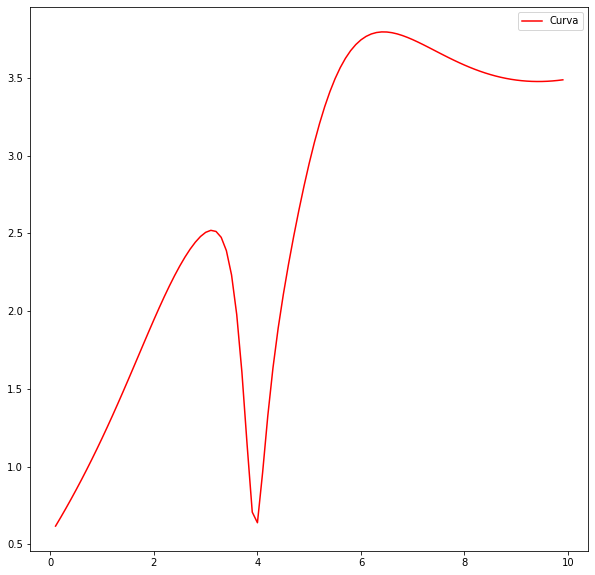

In [27]:
plt.figure(figsize=(10,10))
xlist = np.array(xlist).reshape(-1,)
ylist = np.array(ylist).reshape(-1,)
sns.lineplot(x=np.abs(xlist), y=np.abs(ylist), color='red', label='Curva')
plt.show()
plt.close()

## Mesmo x para diferentes memórias

In [29]:
# Teste de curva
r_model = partial(run_model, model=model, M=M)
x0 = 1.5*np.exp(1j*np.pi/4).reshape(-1,)
ylist = []
tlist = []
for t in range(10,x.shape[0],1):
    x_old = x[t-M-1:t] # Valores de x antigos
    y0 = r_model(x=np.concatenate([x_old, x0])) # Extração do y0
    tlist.append(t)
    ylist.append(y0)

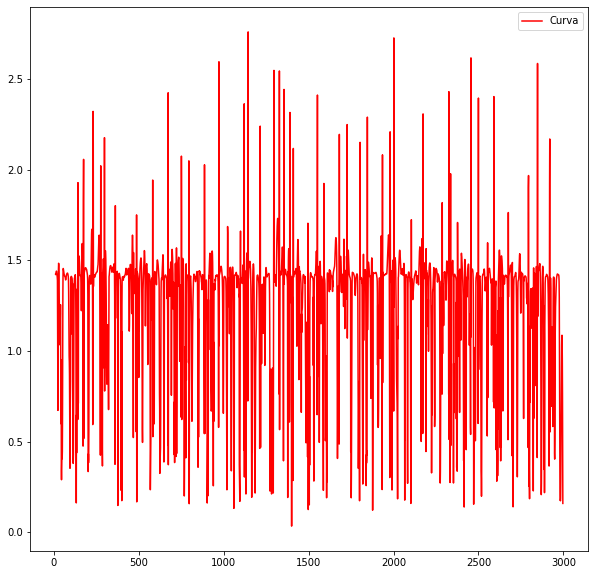

In [30]:
plt.figure(figsize=(10,10))
tlist = np.array(tlist).reshape(-1,)
ylist = np.array(ylist).reshape(-1,)
sns.lineplot(x=np.abs(tlist), y=np.abs(ylist), color='red', label='Curva')
plt.show()
plt.close()

## Efeito da entrada para o problema inverso

In [91]:
r_model = partial(run_model, model=model, M=M)
n, x_n = 2036, x[2036]
x_old = x[n-M-1:n]
x_a = x[n].reshape(-1,)
xt = x[n-M-1:n+1] # Valores de x para extrair o y0
y0 = r_model(x=xt) # Extração do y0
i_problem = partial(inverse_problem, model=model, M=M, y=y0, x_old=x_old)

values = np.array( list(product(range(-30,30,1), range(-30,30,1)))).reshape(-1,2)/10

In [97]:
res = []
print(f'x:   {x_a} -> {np.abs(x_a)}')

for i, x0 in enumerate(values):
    if not i%100:
        print(i)
    res.append(root(i_problem, x0=x0))

x:   [1.6268898-2.004946j] -> [2.581972]
0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500


In [266]:
x0s = [r.x for r in res]
e0s = [r.fun for r in res]
a0s = [x[0]+1j*x[1] for x in x0s]
a0s = np.abs(np.array(a0s)).reshape(-1,1)
e0s = (np.sum(np.array(e0s)**2, axis=1)**0.5).reshape(-1,1)
t0s = np.where(e0s<0.1, a0s, 0)
v0s = np.concatenate([values, a0s, e0s, t0s], axis=1)

In [267]:
dfv = pl.DataFrame(v0s, columns=['real', 'imag', 'abs', 'erro', 'teste'])

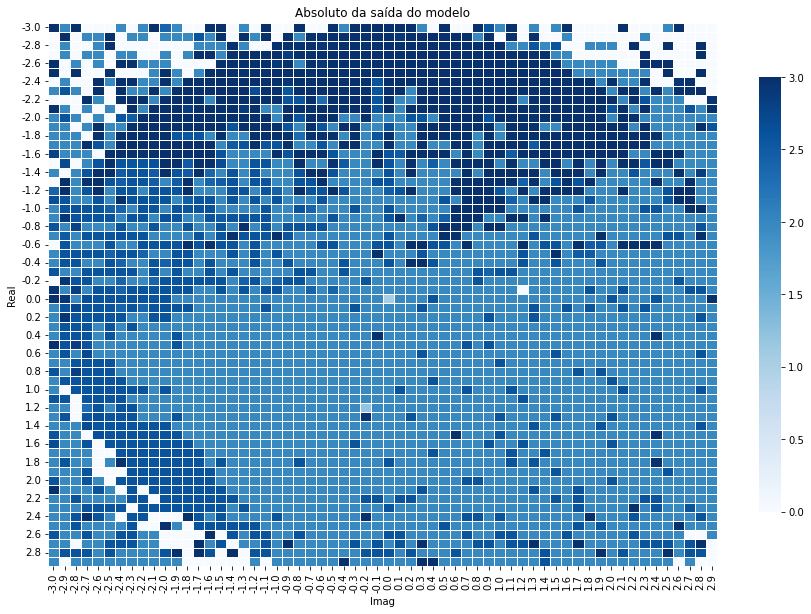

In [268]:
dfpdv = dfv[['real', 'imag', 'abs']].to_pandas()
dfpdv.set_index(['real', 'imag'], inplace=True)
dfunstack = dfpdv.unstack()
plt.figure(figsize=(15,10))
sns.heatmap(dfunstack, cmap="Blues", vmin=0, vmax=3, linewidth=1, cbar_kws={"shrink": .8})
plt.xticks(np.arange(60) + .5, labels=dfunstack.index)
plt.xlabel('Imag')
plt.ylabel('Real')
plt.title('Absoluto da saída do modelo')
plt.show()
plt.close()

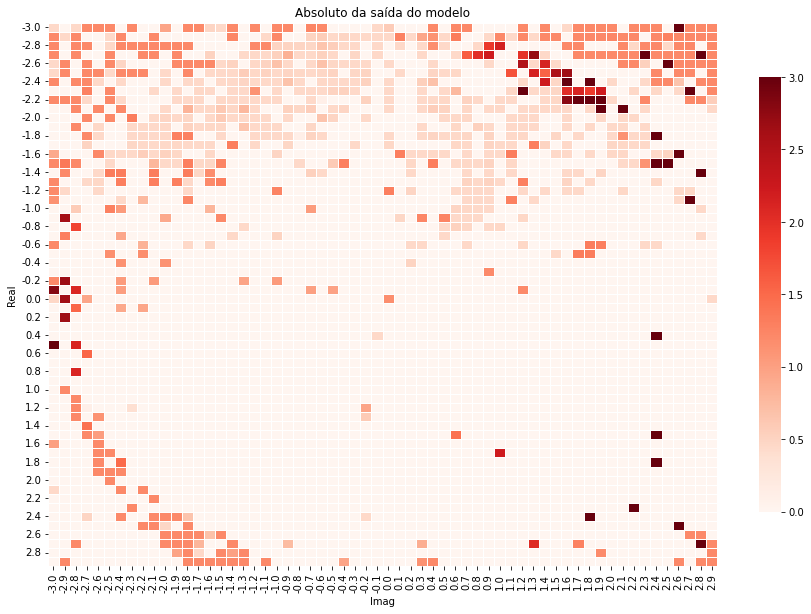

In [269]:
dfpdv = dfv[['real', 'imag', 'erro']].to_pandas()
dfpdv.set_index(['real', 'imag'], inplace=True)
dfunstack = dfpdv.unstack()
plt.figure(figsize=(15,10))
sns.heatmap(dfunstack, cmap="Reds", vmin=0, vmax=3, linewidth=1, cbar_kws={"shrink": .8})
plt.xticks(np.arange(60) + .5, labels=dfunstack.index)
plt.xlabel('Imag')
plt.ylabel('Real')
plt.title('Absoluto da saída do modelo')
plt.show()
plt.close()

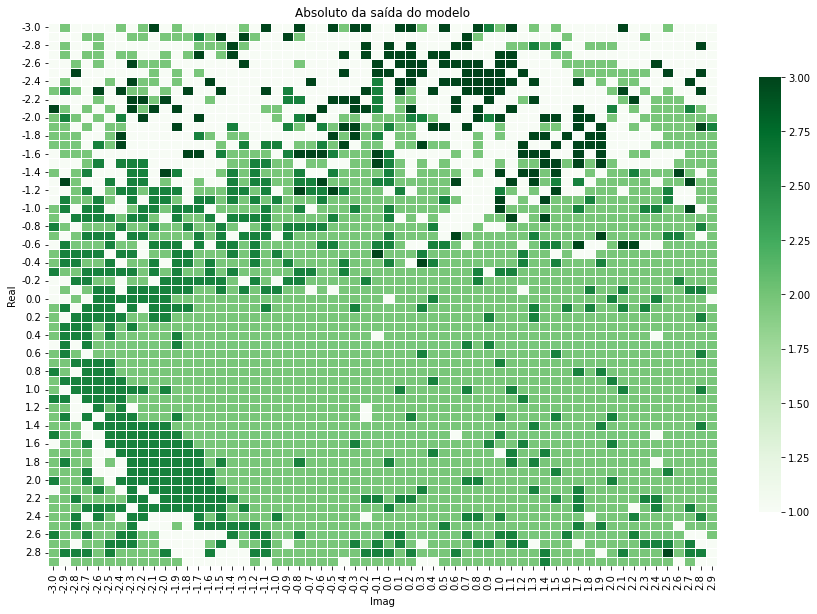

In [272]:
dfpdv = dfv[['real', 'imag', 'teste']].to_pandas()
dfpdv.set_index(['real', 'imag'], inplace=True)
dfunstack = dfpdv.unstack()
plt.figure(figsize=(15,10))
sns.heatmap(dfunstack, cmap="Greens", vmin=1, vmax=3, linewidth=1, cbar_kws={"shrink": .8})
plt.xticks(np.arange(60) + .5, labels=dfunstack.index)
plt.xlabel('Imag')
plt.ylabel('Real')
plt.title('Absoluto da saída do modelo')
plt.show()
plt.close()

- Treinar uma rede neural sem memória para ver a continuidade da função
- Testar o treinamento da inversa da rede para um modelo com ou sem inversa
- Entender melhor a influência do chute inicial no resultado